In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot

from spike_statistics.core import permutation_resampling

13:06:44 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,burst_event_ratio,bursty_spike_ratio,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.398230,0.678064,-0.466923,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,20.224859
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.138014,0.263173,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,27.897271
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.373986,0.659259,-0.572566,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,28.810794
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.087413,0.179245,-0.437492,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,9.462322
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.248771,0.463596,-0.085938,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000


In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,head_mean_vec_len,spacing,orientation,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.040874,0.628784,20.224859,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.017289,0.789388,27.897271,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.124731,0.555402,28.810794,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.101911,0.492250,9.462322,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.053810,0.559905,0.000000,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [7]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# Find all cells with gridness above threshold

In [9]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [10]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [11]:
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 231
Number of animals 4


In [12]:
baseline_i = gridcell_sessions.query('baseline and Hz11')
stimulated_11 = gridcell_sessions.query('frequency==11 and stim_location=="ms"')

baseline_ii = gridcell_sessions.query('baseline and Hz30')
stimulated_30 = gridcell_sessions.query('frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 66
Number of gridcells in stimulated 11Hz ms sessions 61
Number of gridcells in baseline ii sessions 56
Number of gridcells in stimulated 30Hz ms sessions 40


# slice unique units

In [13]:
baseline_i = baseline_i.drop_duplicates('unit_id')
stimulated_11 = stimulated_11.drop_duplicates('unit_id')
baseline_ii = baseline_ii.drop_duplicates('unit_id')
stimulated_30 = stimulated_30.drop_duplicates('unit_id')

In [14]:
print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 63
Number of gridcells in stimulated 11Hz ms sessions 58
Number of gridcells in baseline ii sessions 52
Number of gridcells in stimulated 30Hz ms sessions 38


# Calculate statistics

In [15]:
columns = [
    'average_rate', 'gridness', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 
    'in_field_mean_rate', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score'
]

In [16]:
gridcell_sessions.groupby('stimulated')[columns].mean()

,average_rate,gridness,sparsity,selectivity,information_specificity,max_rate,information_rate,interspike_interval_cv,in_field_mean_rate,out_field_mean_rate,burst_event_ratio,specificity,speed_score
stimulated,,,,,,,,,,,,,
False,8.904501,0.521371,0.618384,5.934539,0.234632,37.437808,1.246546,2.404647,14.717635,6.346875,0.211840,0.478775,0.135495
True,8.392252,0.440296,0.655698,5.977408,0.215736,33.716478,0.964787,2.223636,12.936021,6.122228,0.197264,0.455878,0.104697


In [17]:
gridcell_sessions.query('baseline')[columns].describe()

,average_rate,gridness,sparsity,selectivity,information_specificity,max_rate,information_rate,interspike_interval_cv,in_field_mean_rate,out_field_mean_rate,burst_event_ratio,specificity,speed_score
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,8.904501,0.521371,0.618384,5.934539,0.234632,37.437808,1.246546,2.404647,14.717635,6.346875,0.211840,0.478775,0.135495
std,7.605598,0.337607,0.187934,3.217366,0.200726,16.300117,0.605971,0.756407,9.267522,6.805499,0.080143,0.209531,0.072831
min,0.478349,-0.684924,0.200066,1.533216,0.007807,3.346027,0.117638,1.304387,0.924066,0.159076,0.025000,0.071681,-0.025629
25%,3.518392,0.316326,0.437499,3.729863,0.093252,26.948843,0.786753,1.872991,7.701156,1.669844,0.160795,0.310822,0.084280
50%,6.456882,0.529243,0.642167,4.794970,0.180286,35.064991,1.156087,2.221185,12.212289,4.314913,0.210240,0.436340,0.128603
75%,12.721755,0.783682,0.758097,7.439464,0.312487,44.324873,1.592948,2.770624,20.974026,9.121505,0.267568,0.624834,0.188948
max,59.365312,1.148979,0.976157,18.975875,1.243307,90.160158,3.456796,5.671362,66.350754,56.255544,0.393306,1.066391,0.297548


In [18]:
gridcell_sessions.query("stimulated")[columns].describe()

,average_rate,gridness,sparsity,selectivity,information_specificity,max_rate,information_rate,interspike_interval_cv,in_field_mean_rate,out_field_mean_rate,burst_event_ratio,specificity,speed_score
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,8.392252,0.440296,0.655698,5.977408,0.215736,33.716478,0.964787,2.223636,12.936021,6.122228,0.197264,0.455878,0.104697
std,6.057001,0.357038,0.211704,3.702400,0.235916,13.249312,0.572972,0.819734,7.211895,5.366332,0.082164,0.236777,0.081989
min,0.198337,-0.516914,0.172684,1.930026,0.013088,2.846281,0.063173,1.110672,0.524639,0.099060,0.008475,0.097718,-0.138128
25%,3.579184,0.265949,0.458493,3.044303,0.066656,25.555110,0.564279,1.620472,7.555760,1.733624,0.146755,0.248057,0.056903
50%,6.838561,0.399053,0.699561,4.891855,0.128562,31.402558,0.862413,2.084020,11.451560,4.234871,0.192948,0.376143,0.106314
75%,11.934599,0.749561,0.842332,8.001587,0.300713,42.334786,1.190324,2.673991,17.335356,8.583415,0.247405,0.684623,0.149313
max,24.858738,1.155123,0.967003,19.911477,1.359164,65.990793,3.182285,6.526960,34.489913,21.696265,0.393037,1.091064,0.390079


# Create nice table

In [19]:
def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(column, stim, base):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        stim[column].dropna(), 
        base[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, stim, base):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        stim[column].dropna(), 
        base[column].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [20]:
_stim_data = gridcell_sessions.query('stimulated')
_base_data = gridcell_sessions.query('baseline and i')

result = pd.DataFrame()

result['Baseline I'] = _base_data[columns].agg(summarize)
result['Stimulated'] = _stim_data[columns].agg(summarize)


result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))

result.to_latex(output_path / "statistics" / "statistics.tex")
result.to_latex(output_path / "statistics" / "statistics.csv")
result

,Baseline I,Stimulated,MWU,PRS
Average rate,8.61 ± 0.75 (71),8.39 ± 0.60 (102),"3599.00, 0.947","0.55, 0.764"
Gridness,0.51 ± 0.04 (71),0.44 ± 0.04 (102),"3208.00, 0.203","0.13, 0.141"
Sparsity,0.61 ± 0.02 (71),0.66 ± 0.02 (102),"4170.00, 0.091","0.06, 0.179"
Selectivity,5.91 ± 0.37 (71),5.98 ± 0.37 (102),"3460.00, 0.620","0.10, 0.869"
Information specificity,0.25 ± 0.03 (71),0.22 ± 0.02 (102),"2944.00, 0.037","0.05, 0.033"
Max rate,36.55 ± 1.78 (71),33.72 ± 1.31 (102),"3291.00, 0.309","3.19, 0.195"
Information rate,1.30 ± 0.07 (71),0.96 ± 0.06 (102),"2385.00, 0.000","0.32, 0.000"
Interspike interval cv,2.42 ± 0.10 (71),2.22 ± 0.08 (102),"3034.00, 0.070","0.12, 0.392"
In-field mean rate,14.43 ± 1.00 (71),12.94 ± 0.71 (102),"3368.00, 0.436","0.39, 0.812"
Out-field mean rate,6.05 ± 0.62 (71),6.12 ± 0.53 (102),"3600.00, 0.950","0.08, 0.946"


In [21]:
_stim_data = stimulated_11
_base_data = baseline_i

result = pd.DataFrame()

result['Baseline I'] = _base_data[columns].agg(summarize)
result['11 Hz'] = _stim_data[columns].agg(summarize)


result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_11.tex")
result.to_latex(output_path / "statistics" / "statistics_11.csv")
result

,Baseline I,11 Hz,MWU,PRS
Average rate,8.96 ± 0.80 (63),8.80 ± 0.85 (58),"1781.00, 0.813","0.04, 0.972"
Gridness,0.53 ± 0.05 (63),0.41 ± 0.05 (58),"1459.00, 0.057","0.21, 0.043"
Sparsity,0.63 ± 0.02 (63),0.67 ± 0.03 (58),"2138.00, 0.107","0.07, 0.119"
Selectivity,5.76 ± 0.40 (63),5.69 ± 0.50 (58),"1687.00, 0.469","0.00, 0.982"
Information specificity,0.24 ± 0.03 (63),0.21 ± 0.03 (58),"1452.00, 0.052","0.06, 0.032"
Max rate,37.39 ± 1.91 (63),33.11 ± 1.85 (58),"1538.00, 0.134","4.06, 0.122"
Information rate,1.31 ± 0.08 (63),0.94 ± 0.08 (58),"1143.00, 0.000","0.32, 0.003"
Interspike interval cv,2.39 ± 0.10 (63),2.19 ± 0.12 (58),"1462.00, 0.059","0.18, 0.135"
In-field mean rate,14.88 ± 1.05 (63),13.27 ± 1.04 (58),"1633.00, 0.315","0.77, 0.688"
Out-field mean rate,6.37 ± 0.67 (63),6.57 ± 0.77 (58),"1795.00, 0.870","0.47, 0.724"


In [22]:
_stim_data = stimulated_30
_base_data = baseline_ii

result = pd.DataFrame()

result['Baseline II'] = _base_data[columns].agg(summarize)
result['30 Hz'] = _stim_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_30.tex")
result.to_latex(output_path / "statistics" / "statistics_30.csv")
result

,Baseline II,30 Hz,MWU,PRS
Average rate,8.29 ± 0.87 (52),7.61 ± 0.87 (38),"958.00, 0.810","0.27, 0.800"
Gridness,0.54 ± 0.04 (52),0.48 ± 0.06 (38),"914.00, 0.548","0.04, 0.601"
Sparsity,0.63 ± 0.03 (52),0.64 ± 0.03 (38),"1040.00, 0.674","0.06, 0.393"
Selectivity,5.96 ± 0.46 (52),6.42 ± 0.60 (38),"1019.00, 0.803","0.20, 0.847"
Information specificity,0.21 ± 0.02 (52),0.22 ± 0.03 (38),"950.00, 0.759","0.04, 0.502"
Max rate,36.27 ± 2.34 (52),33.49 ± 1.89 (38),"943.00, 0.716","2.90, 0.555"
Information rate,1.13 ± 0.08 (52),0.98 ± 0.09 (38),"827.00, 0.190","0.07, 0.334"
Interspike interval cv,2.37 ± 0.09 (52),2.23 ± 0.11 (38),"869.00, 0.333","0.17, 0.476"
In-field mean rate,13.79 ± 1.12 (52),12.21 ± 0.98 (38),"912.00, 0.537","1.06, 0.455"
Out-field mean rate,5.80 ± 0.72 (52),5.36 ± 0.73 (38),"959.00, 0.816","0.13, 0.912"


In [23]:
_stim_data = stimulated_30
_base_data = baseline_i

result = pd.DataFrame()

result['Baseline I'] = _base_data[columns].agg(summarize)
result['30 Hz'] = _stim_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_b_i_30.tex")
result.to_latex(output_path / "statistics" / "statistics_b_i_30.csv")
result

,Baseline I,30 Hz,MWU,PRS
Average rate,8.96 ± 0.80 (63),7.61 ± 0.87 (38),"1081.00, 0.418","0.27, 0.806"
Gridness,0.53 ± 0.05 (63),0.48 ± 0.06 (38),"1094.00, 0.472","0.08, 0.361"
Sparsity,0.63 ± 0.02 (63),0.64 ± 0.03 (38),"1261.00, 0.656","0.03, 0.638"
Selectivity,5.76 ± 0.40 (63),6.42 ± 0.60 (38),"1276.00, 0.582","0.86, 0.293"
Information specificity,0.24 ± 0.03 (63),0.22 ± 0.03 (38),"1076.00, 0.398","0.05, 0.165"
Max rate,37.39 ± 1.91 (63),33.49 ± 1.89 (38),"1027.00, 0.235","3.99, 0.188"
Information rate,1.31 ± 0.08 (63),0.98 ± 0.09 (38),"797.00, 0.005","0.32, 0.047"
Interspike interval cv,2.39 ± 0.10 (63),2.23 ± 0.11 (38),"1100.00, 0.499","0.01, 0.993"
In-field mean rate,14.88 ± 1.05 (63),12.21 ± 0.98 (38),"1018.00, 0.211","1.74, 0.276"
Out-field mean rate,6.37 ± 0.67 (63),5.36 ± 0.73 (38),"1079.00, 0.410","0.51, 0.631"


In [24]:
_stim_data = stimulated_30
_base_data = stimulated_11

result = pd.DataFrame()

result['11 Hz'] = _base_data[columns].agg(summarize)
result['30 Hz'] = _stim_data[columns].agg(summarize)


result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_11_vs_30.tex")
result.to_latex(output_path / "statistics" / "statistics_11_vs_30.csv")
result

,11 Hz,30 Hz,MWU,PRS
Average rate,8.80 ± 0.85 (58),7.61 ± 0.87 (38),"1010.00, 0.493","0.23, 0.893"
Gridness,0.41 ± 0.05 (58),0.48 ± 0.06 (38),"1259.00, 0.241","0.13, 0.094"
Sparsity,0.67 ± 0.03 (58),0.64 ± 0.03 (38),"1002.00, 0.456","0.04, 0.561"
Selectivity,5.69 ± 0.50 (58),6.42 ± 0.60 (38),"1260.00, 0.238","0.85, 0.335"
Information specificity,0.21 ± 0.03 (58),0.22 ± 0.03 (38),"1231.00, 0.336","0.01, 0.732"
Max rate,33.11 ± 1.85 (58),33.49 ± 1.89 (38),"1136.00, 0.802","0.07, 0.993"
Information rate,0.94 ± 0.08 (58),0.98 ± 0.09 (38),"1171.00, 0.608","0.01, 0.789"
Interspike interval cv,2.19 ± 0.12 (58),2.23 ± 0.11 (38),"1228.00, 0.347","0.17, 0.328"
In-field mean rate,13.27 ± 1.04 (58),12.21 ± 0.98 (38),"1058.00, 0.744","0.97, 0.637"
Out-field mean rate,6.57 ± 0.77 (58),5.36 ± 0.73 (38),"1019.00, 0.537","0.04, 0.958"


In [25]:
_stim_data = baseline_i
_base_data = baseline_ii

result = pd.DataFrame()

result['Baseline I'] = _stim_data[columns].agg(summarize)
result['Baseline II'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_base_i_vs_base_ii.tex")
result.to_latex(output_path / "statistics" / "statistics_base_i_vs_base_ii.csv")
result

,Baseline I,Baseline II,MWU,PRS
Average rate,8.96 ± 0.80 (63),8.29 ± 0.87 (52),"1756.00, 0.509","0.55, 0.674"
Gridness,0.53 ± 0.05 (63),0.54 ± 0.04 (52),"1664.00, 0.886","0.04, 0.550"
Sparsity,0.63 ± 0.02 (63),0.63 ± 0.03 (52),"1652.00, 0.940","0.03, 0.648"
Selectivity,5.76 ± 0.40 (63),5.96 ± 0.46 (52),"1542.00, 0.592","0.66, 0.360"
Information specificity,0.24 ± 0.03 (63),0.21 ± 0.02 (52),"1718.00, 0.655","0.01, 0.812"
Max rate,37.39 ± 1.91 (63),36.27 ± 2.34 (52),"1757.00, 0.505","1.09, 0.610"
Information rate,1.31 ± 0.08 (63),1.13 ± 0.08 (52),"1929.00, 0.103","0.25, 0.140"
Interspike interval cv,2.39 ± 0.10 (63),2.37 ± 0.09 (52),"1572.00, 0.713","0.16, 0.479"
In-field mean rate,14.88 ± 1.05 (63),13.79 ± 1.12 (52),"1763.00, 0.484","0.68, 0.690"
Out-field mean rate,6.37 ± 0.67 (63),5.80 ± 0.72 (52),"1737.00, 0.580","0.38, 0.586"


# Violinplot

In [26]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7, 3), 
    'figure.dpi': 150
})

In [27]:
# colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
# labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']

stuff = {
    '': {
        'base': gridcell_sessions.query('baseline and i'),
        'stim': gridcell_sessions.query('stimulated')
    },
    '_11': {
        'base': baseline_i,
        'stim': stimulated_11
    },
    '_30': {
        'base': baseline_ii,
        'stim': stimulated_30
    }
}

label = {
    '': ['Baseline I   ', '   Stimulated'],
    '_11': ['Baseline I ', '  11 Hz'],
    '_30': ['Baseline II ', '  30 Hz']
}

colors = {
    '': None,
    '_11': ['#1b9e77', '#d95f02'],
    '_30': ['#7570b3', '#e7298a']
}

# Information rate


U-test: U value 4298.0 p value 0.036830785214103115
_11
U-test: U value 2202.0 p value 0.05201320820170774
_30
U-test: U value 1026.0 p value 0.7593436297175663


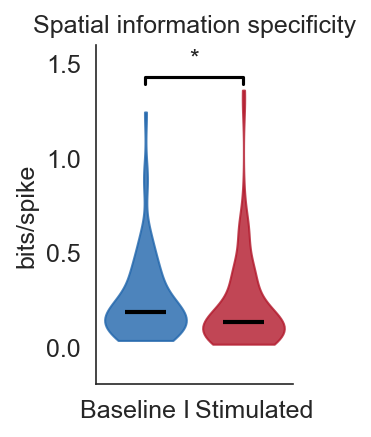

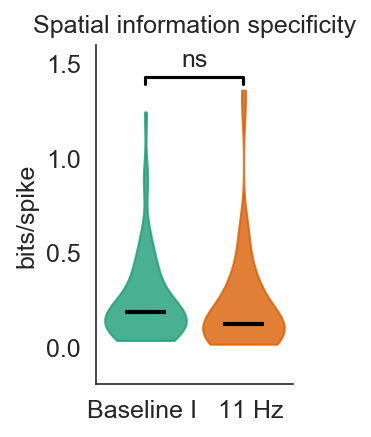

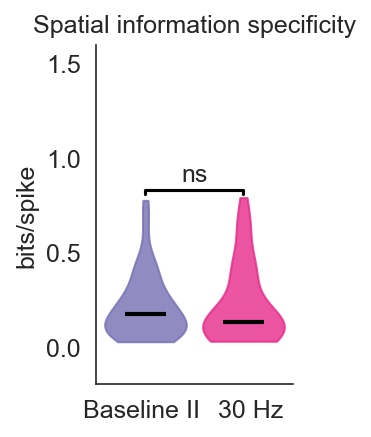

In [28]:
for key, dd in stuff.items():
    baseline = dd['base']['information_specificity'].to_numpy()
    stimulated = dd['stim']['information_specificity'].to_numpy()
    print(key)
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Spatial information specificity")
    plt.ylabel("bits/spike")
    plt.ylim(-0.2, 1.6)

    plt.savefig(output_path / "figures" / f"information_specificity{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"information_specificity{key}.png", dpi=600, bbox_inches="tight")


U-test: U value 4857.0 p value 0.00013747228542563089
_11
U-test: U value 2511.0 p value 0.0003908085167909787
_30
U-test: U value 1149.0 p value 0.18980799435841422


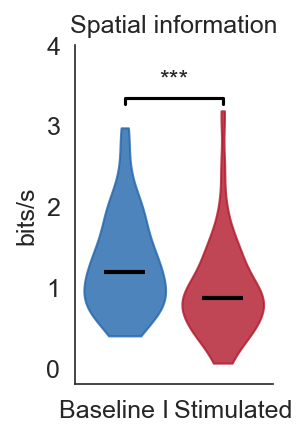

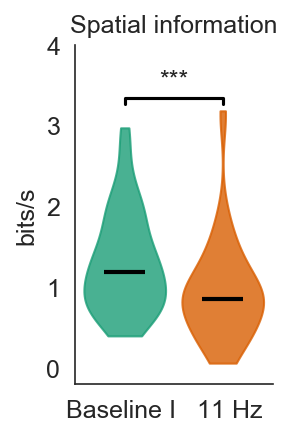

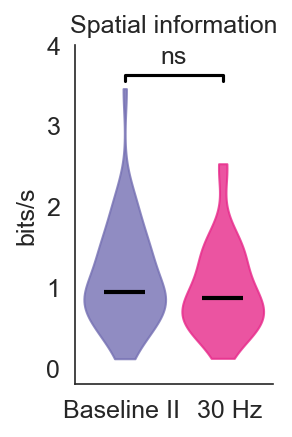

In [29]:

for key, dd in stuff.items():
    baseline = dd['base']['information_rate'].to_numpy()
    stimulated = dd['stim']['information_rate'].to_numpy()
    print(key)
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Spatial information")
    plt.ylabel("bits/s")
    plt.ylim(-0.2, 4)

    plt.savefig(output_path / "figures" / f"spatial_information{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"spatial_information{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 3974.0 p value 0.2766869426478231
U-test: U value 2049.0 p value 0.25046855806374924
U-test: U value 1000.0 p value 0.9251527394243083


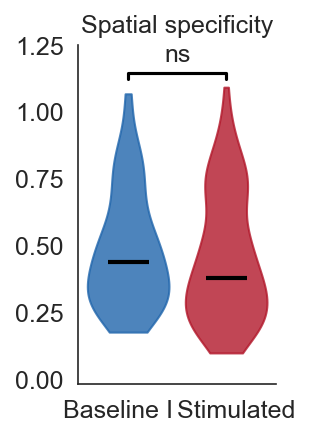

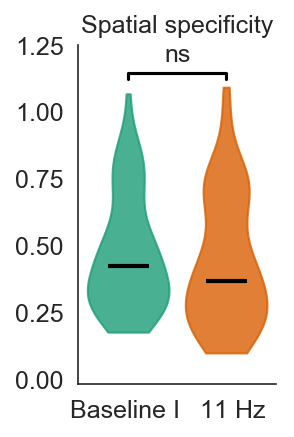

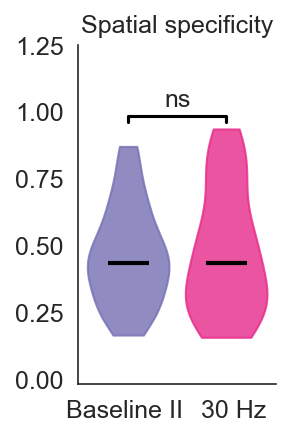

In [30]:
for key, dd in stuff.items():
    baseline = dd['base']['specificity'].to_numpy()
    stimulated = dd['stim']['specificity'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Spatial specificity")
    plt.ylabel("")
    plt.ylim(-0.02, 1.25)
    plt.savefig(output_path / "figures" / f"specificity{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"specificity{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 3643.0 p value 0.9471010896899097
U-test: U value 1873.0 p value 0.8133796041365939
U-test: U value 1018.0 p value 0.8095631030980726


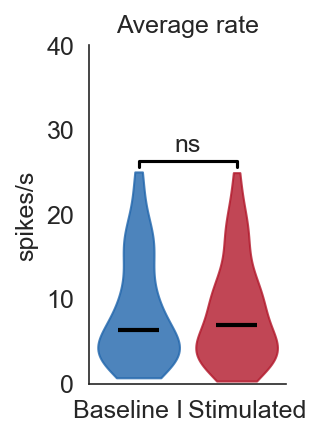

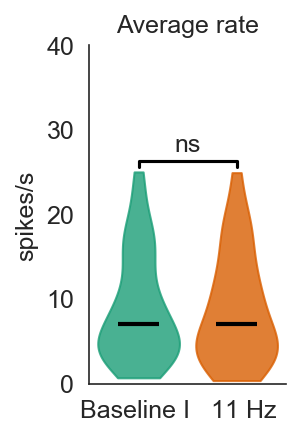

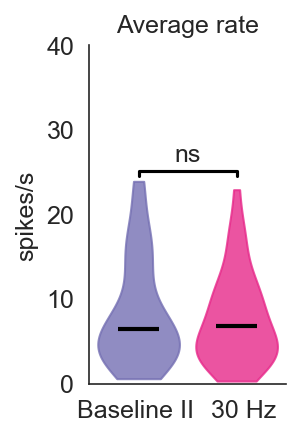

In [31]:

for key, dd in stuff.items():
    baseline = dd['base']['average_rate'].to_numpy()
    stimulated = dd['stim']['average_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Average rate")
    plt.ylabel("spikes/s")
    plt.ylim(-0.2, 40)

    plt.savefig(output_path / "figures" / f"average_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"average_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 3951.0 p value 0.30924120740340955
U-test: U value 2116.0 p value 0.13443770008325492
U-test: U value 1033.0 p value 0.7162113753904321


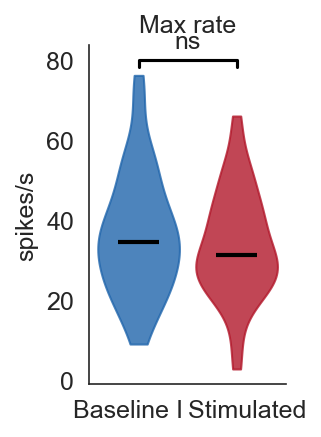

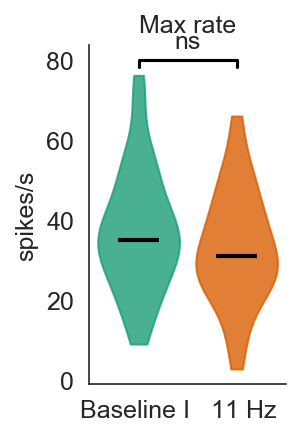

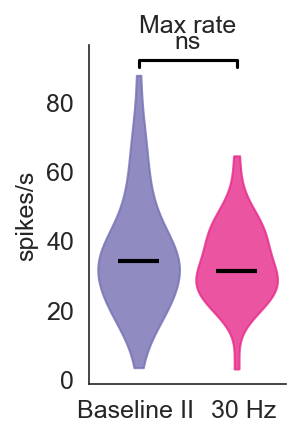

In [32]:
for key, dd in stuff.items():
    baseline = dd['base']['max_rate'].to_numpy()
    stimulated = dd['stim']['max_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Max rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.2, 45)

    plt.savefig(output_path / "figures" / f"max_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"max_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 4208.0 p value 0.0703111829950676
U-test: U value 2192.0 p value 0.05860549066385172
U-test: U value 1107.0 p value 0.3330227188913163


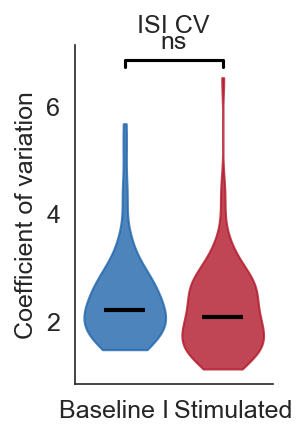

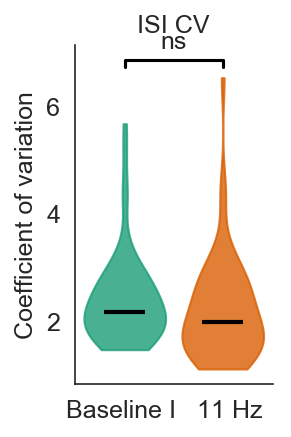

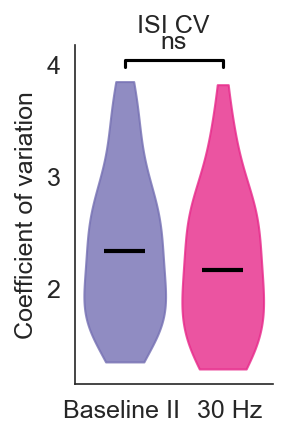

In [33]:

for key, dd in stuff.items():
    baseline = dd['base']['interspike_interval_cv'].to_numpy()
    stimulated = dd['stim']['interspike_interval_cv'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("ISI CV")
    plt.ylabel("Coefficient of variation")
    # plt.ylim(0.9, 5)

    plt.savefig(output_path / "figures" / f"isi_cv{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"isi_cv{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 3874.0 p value 0.4358627795642821
U-test: U value 2021.0 p value 0.31540792775479376
U-test: U value 1064.0 p value 0.5373862857775564


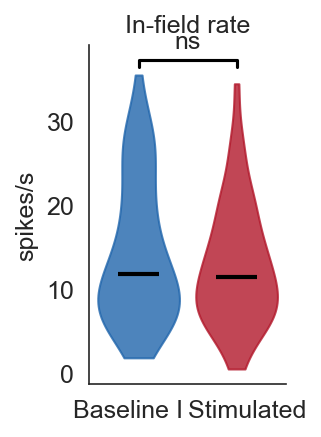

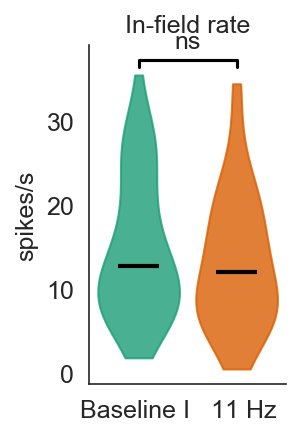

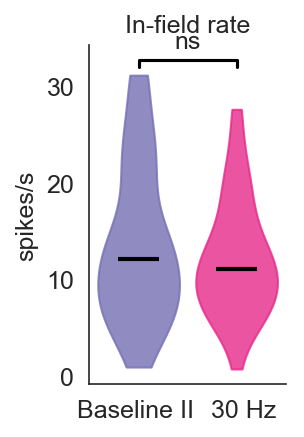

In [34]:

for key, dd in stuff.items():
    baseline = dd['base']['in_field_mean_rate'].to_numpy()
    stimulated = dd['stim']['in_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("In-field rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.1, 18)

    plt.savefig(output_path / "figures" / f"in_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"in_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 3642.0 p value 0.9495581436162017
U-test: U value 1859.0 p value 0.8701783404716995
U-test: U value 1017.0 p value 0.8159007523250839


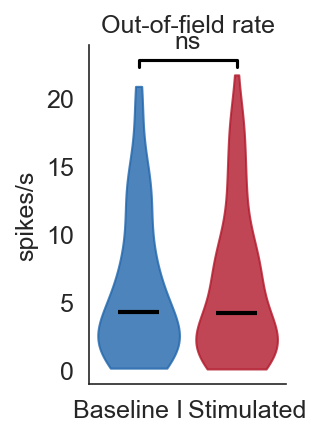

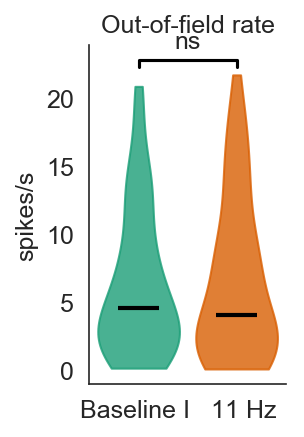

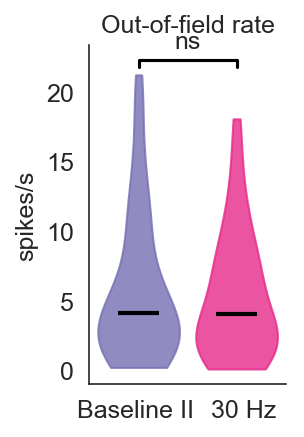

In [35]:

for key, dd in stuff.items():
    baseline = dd['base']['out_field_mean_rate'].to_numpy()
    stimulated = dd['stim']['out_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Out-of-field rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.2, 8)

    plt.savefig(output_path / "figures" / f"out_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"out_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 4152.0 p value 0.10161200342185885
U-test: U value 1757.0 p value 0.718407479245363
U-test: U value 1300.0 p value 0.010937547927479946


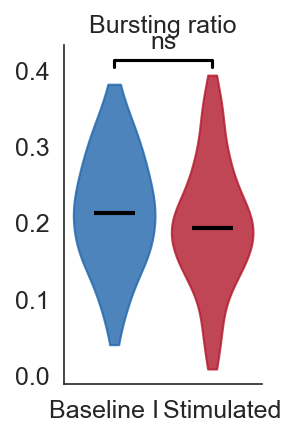

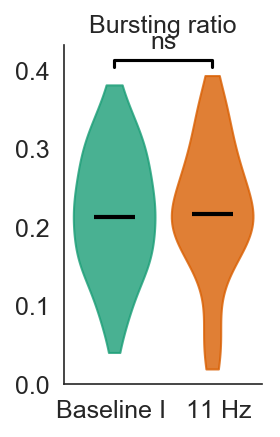

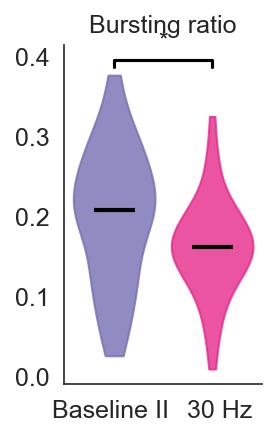

In [36]:
for key, dd in stuff.items():
    baseline = dd['base']['burst_event_ratio'].to_numpy()
    stimulated = dd['stim']['burst_event_ratio'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Bursting ratio")
    plt.ylabel("")
    # plt.ylim(-0.02, 0.60)

    plt.savefig(output_path / "figures" / f"burst_event_ratio{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"burst_event_ratio{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 3934.0 p value 0.3348681711667292
U-test: U value 2022.0 p value 0.3129134904118731
U-test: U value 1069.0 p value 0.5107849438878747


/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


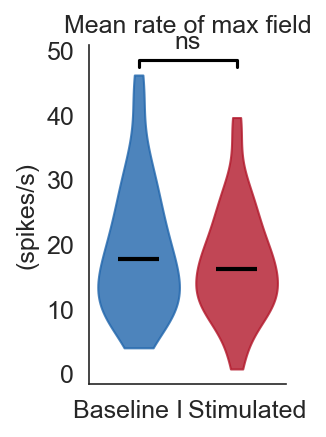

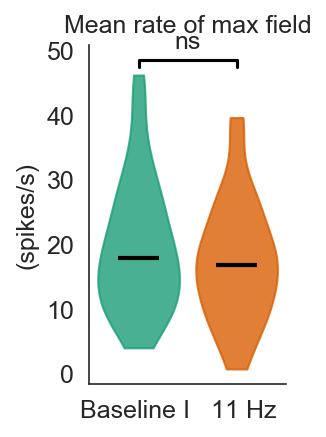

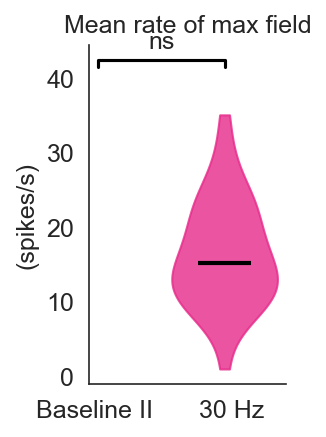

In [37]:
for key, dd in stuff.items():
    baseline = dd['base']['max_field_mean_rate'].to_numpy()
    stimulated = dd['stim']['max_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Mean rate of max field")
    plt.ylabel("(spikes/s)")
    # plt.ylim(-0.5,25)

    plt.savefig(output_path / "figures" / f"max_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"max_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 4196.0 p value 0.07625033158277
U-test: U value 1789.0 p value 0.8457359656438074
U-test: U value 1312.0 p value 0.008224362184318894


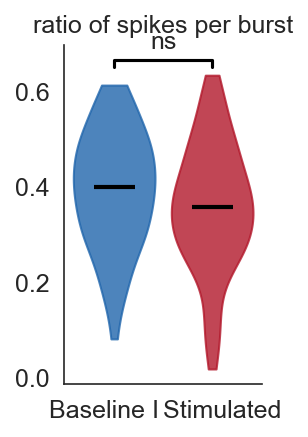

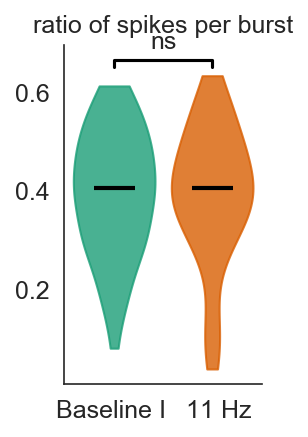

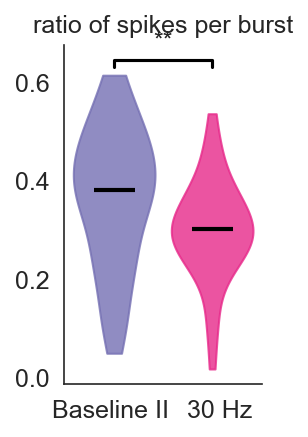

In [38]:
for key, dd in stuff.items():
    baseline = dd['base']['bursty_spike_ratio'].to_numpy()
    stimulated = dd['stim']['bursty_spike_ratio'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("ratio of spikes per burst")
    plt.ylabel("")
    # plt.ylim(-0.03,0.9)

    plt.savefig(output_path / "figures" / f"bursty_spike_ratio{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"bursty_spike_ratio{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 4034.0 p value 0.20303646513670592
U-test: U value 2195.0 p value 0.05655864319615998
U-test: U value 1062.0 p value 0.5482183981489739


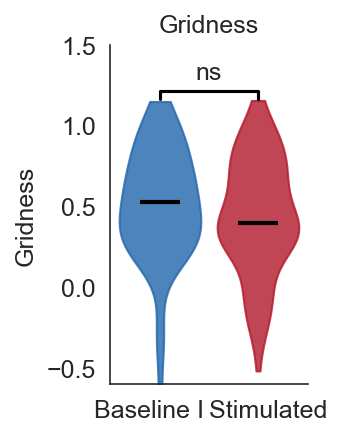

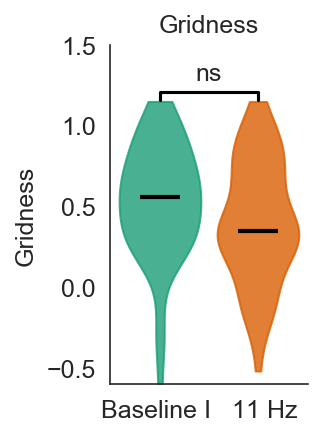

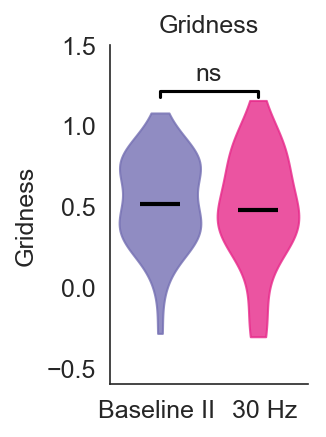

In [39]:

for key, dd in stuff.items():
    baseline = dd['base']['gridness'].to_numpy()
    stimulated = dd['stim']['gridness'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Gridness")
    plt.ylabel("Gridness")
    plt.ylim(-0.6, 1.5)

    plt.savefig(output_path / "figures" / f"gridness{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"gridness{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 4696.0 p value 0.0009136914115846572
U-test: U value 2276.0 p value 0.019967404084342423
U-test: U value 1192.0 p value 0.09642850317783999


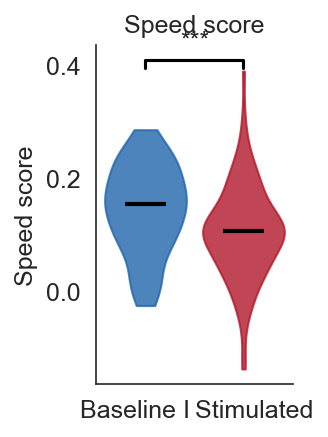

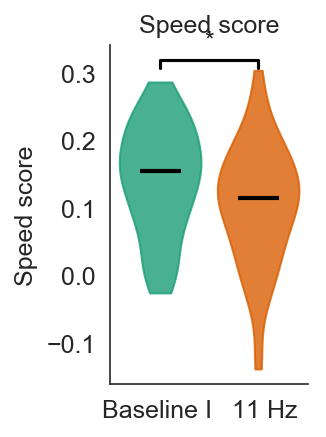

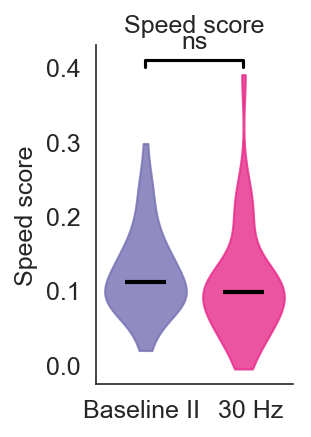

In [40]:
for key, dd in stuff.items(): #TODO narrow broad spiking
    baseline = dd['base']['speed_score'].to_numpy()
    stimulated = dd['stim']['speed_score'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key], colors=colors[key])
    plt.title("Speed score")
    plt.ylabel("Speed score")
    # plt.ylim(-0.1, 0.5)

    plt.savefig(output_path / "figures" / f"speed_score{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"speed_score{key}.png", dpi=600, bbox_inches="tight")

# inihibitory cells

In [46]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))
# stim_results has old unit id's but correct on (action, unit_name, channel_group)
stim_results = stim_results.drop('unit_id', axis=1)

data = data.merge(stim_results, how='left')

waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

data = data.merge(waveform_results, how='left')

data.bs = data.bs.astype(bool)

data.loc[data.eval('not t_i_peak.isnull() and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak.isnull() and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

U-test: U value 994.0 p value 0.9314999104389459


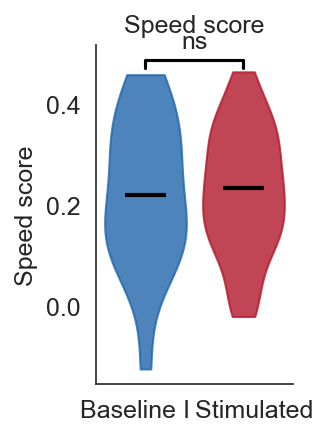

In [53]:
baseline = data.query('ns_inhibited and baseline and i')['speed_score'].to_numpy()
stimulated = data.query('ns_inhibited and stimulated')['speed_score'].to_numpy()
plt.figure()
violinplot(baseline, stimulated, xticks=label[''], colors=colors[''])
plt.title("Speed score")
plt.ylabel("Speed score")
# plt.ylim(-0.1, 0.5)

plt.savefig(output_path / "figures" / f"speed_score_ns_inhibited.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / f"speed_score_ns_inhibited.png", dpi=600, bbox_inches="tight")

# Register in Expipe

In [42]:
action = project.require_action("comparisons-gridcells")

In [43]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_b_i_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11_vs_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gr

In [44]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_gridcells.ipynb")